# Projeto de Sinais e Sistemas para Computação (SSC)

## II - Extração de Características de Sinais Digitais

Este notebook implementa diferentes métodos de extração de características de sinais biomédicos pré-processados:
- **Características no domínio do tempo**: Estatísticas descritivas e morfológicas
- **Características no domínio da frequência**: Análise espectral e componentes de Fourier  
- **Características informacionais**: Entropia de Shannon e complexidade
- **Pipeline automatizado**: Processamento em lote otimizado

### Objetivos
- Extrair características discriminativas dos sinais pré-processados
- Implementar pipeline robusto para datasets grandes (PTB-XL)
- Criar dataset estruturado para algoritmos de classificação
- Análise exploratória das características extraídas

### Pré-requisitos
- Dados pré-processados do **Notebook I** disponíveis em `../data/processed/`
- Sinais filtrados, normalizados e com qualidade verificada

## 1. Importação de Bibliotecas

Carregamos as bibliotecas necessárias para extração de características e o módulo personalizado desenvolvido.

In [5]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq
import wfdb
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#matplotlib.use('Agg')
%matplotlib inline

import sys
import time as time_module
from datetime import datetime
import os
import json
import glob

import warnings
warnings.filterwarnings('ignore')

# Importar nosso módulo de pré-processamento
sys.path.append('../src')
from feature_extraction import (
    load_signal_processado, 
    extract_time_features, 
    extract_frequency_features,
    extract_shannon_entropy,
    aplicar_janelamento,
    pipeline_extract_features,
    save_features,
    visualizar_features,
    pipeline_multicanal
)

# Imports para análise avançada
from sklearn.decomposition import PCA  # Para análise de componentes principais
from sklearn.preprocessing import StandardScaler  # Para normalização


# Configurações de visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

## 2. Carregamento e Preparação dos Dados

Nesta seção carregamos os dados pré-processados do **Notebook I** e realizamos uma análise inicial da disponibilidade e qualidade dos dados processados.

In [35]:
# Verificar se existem dados processados
processed_dir = "../data/processed"
arquivos_processados = []

print("CARREGAMENTO DOS DADOS PRÉ-PROCESSADOS")
print("="*50)

# Buscar todos os arquivos .npz em todas as subpastas
for root, dirs, files in os.walk(processed_dir):
    for file in files:
        if file.endswith('_processed.npz'):
            arquivos_processados.append(os.path.join(root, file))

print(f"Encontrados {len(arquivos_processados)} arquivos processados")

if len(arquivos_processados) == 0:
    print("Nenhum arquivo processado encontrado!")

    # CRIAR DADOS SINTÉTICOS OBRIGATÓRIOS
    fs = 100  # Frequência de amostragem
    duracao = 10  # 10 segundos
    t = np.linspace(0, duracao, duracao * fs)
    
    # Gerar ECG sintético
    ecg_base = (
        0.8 * np.sin(2*np.pi*1.2*t) +           # Batimento cardíaco ~72 bpm
        0.3 * np.sin(2*np.pi*0.3*t) +           # Respiração
        0.1 * np.sin(2*np.pi*3.6*t) +           # Harmônicos
        0.05 * np.random.randn(len(t))          # Ruído
    )
    
    # Simular 12 derivações (padrão ECG)
    signals_exemplo = np.zeros((len(t), 12))
    for i in range(12):
        # Cada derivação com variação realista
        amplitude = 0.5 + 0.5*np.random.rand()
        phase = 2*np.pi*np.random.rand()
        noise = 0.02*np.random.randn(len(t))
        signals_exemplo[:, i] = amplitude * ecg_base + noise
    
    metadata_exemplo = {
        'fs': fs,
        'ecg_id': 99999,  # ID sintético
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
        'shape': signals_exemplo.shape,
        'modo_sintetico': True
    }
    
    print(f" Dados sintéticos criados: {signals_exemplo.shape}")
    print(f" Frequência de amostragem: {fs} Hz")

else:
    print("Dados pré-processados disponíveis!")

print("\n" + "="*50)

# Exemplo de carregamento com um arquivo específico
print("\nEXEMPLO DE CARREGAMENTO - ANÁLISE DETALHADA")
print("="*50)

if len(arquivos_processados) > 0:
    # Usar o primeiro arquivo como exemplo
    arquivo_exemplo = arquivos_processados[0]
    print(f"Arquivo selecionado: {arquivo_exemplo.split('/')[-1]}")
    
    try:
        # Carregar dados
        signals_exemplo, metadata_exemplo = load_signal_processado(arquivo_exemplo)
        fs = metadata_exemplo.get('fs', 100)
        
        print(f"Shape do sinal: {signals_exemplo.shape}")
        print(f"Frequência de amostragem: {fs} Hz")
        print(f"ECG ID: {metadata_exemplo.get('ecg_id', 'N/A')}")
        print(f"Timestamp: {metadata_exemplo.get('timestamp', 'N/A')}")
        
        # Informações detalhadas
        if len(signals_exemplo.shape) == 2:
            n_samples, n_channels = signals_exemplo.shape
            duracao = n_samples / fs
            print(f"Duração: {duracao:.1f} segundos")
            print(f"Canais: {n_channels}")
            
            # Estatísticas básicas do sinal
            print(f"\nESTATÍSTICAS BÁSICAS DO SINAL:")
            print(f"   Amplitude média: {np.mean(signals_exemplo):.6f}")
            print(f"   Desvio padrão: {np.std(signals_exemplo):.6f}")
            print(f"   Valor mínimo: {np.min(signals_exemplo):.6f}")
            print(f"   Valor máximo: {np.max(signals_exemplo):.6f}")
            
    except Exception as e:
        print(f"Erro ao carregar: {str(e)}")

if 'signals_exemplo' not in locals():
    raise RuntimeError(" ERRO CRÍTICO: Variável 'signals_exemplo' não foi definida")

if 'fs' not in locals():
    fs = 100 
    print(f" Usando fs padrão: {fs} Hz")

# ...existing code...
if len(signals_exemplo.shape) == 2:
    n_samples, n_channels = signals_exemplo.shape
    duracao = n_samples / fs
    print(f"Duração: {duracao:.1f} segundos")
    print(f"Canais: {n_channels}")
    
    # Estatísticas básicas do sinal
    print(f"\nESTATÍSTICAS BÁSICAS DO SINAL:")
    print(f"   Amplitude média: {np.mean(signals_exemplo):.6f}")
    print(f"   Desvio padrão: {np.std(signals_exemplo):.6f}")
    print(f"   Valor mínimo: {np.min(signals_exemplo):.6f}")
    print(f"   Valor máximo: {np.max(signals_exemplo):.6f}")
else:
    print("Sinal com dimensão inesperada")
    print(f"Shape: {signals_exemplo.shape}")

CARREGAMENTO DOS DADOS PRÉ-PROCESSADOS
Encontrados 21837 arquivos processados
Dados pré-processados disponíveis!


EXEMPLO DE CARREGAMENTO - ANÁLISE DETALHADA
Arquivo selecionado: 06205_processed.npz
Shape do sinal: (1000, 12)
Frequência de amostragem: 100 Hz
ECG ID: 6205
Timestamp: 20250730_222259
Duração: 10.0 segundos
Canais: 12

ESTATÍSTICAS BÁSICAS DO SINAL:
   Amplitude média: 0.000000
   Desvio padrão: 1.000000
   Valor mínimo: -4.016399
   Valor máximo: 5.270090
Duração: 10.0 segundos
Canais: 12

ESTATÍSTICAS BÁSICAS DO SINAL:
   Amplitude média: 0.000000
   Desvio padrão: 1.000000
   Valor mínimo: -4.016399
   Valor máximo: 5.270090


## 2.1 Extração de Características no Domínio do Tempo

As características temporais capturam propriedades **estatísticas** e **morfológicas** do sinal ao longo do tempo, fundamentais para classificação de sinais biomédicos.

### Características Implementadas:
- **Estatísticas Básicas**: média, desvio padrão, variância, min/max
- **Estatísticas Robustas**: mediana, IQR, percentis
- **Forma da Distribuição**: assimetria (skewness), curtose (kurtosis)
- **Características Morfológicas**: cruzamentos por zero, picos, RMS
- **Dinâmica Temporal**: range, energia, momentos estatísticos

### Relevância para ECG:
- **Mean/STD**: Amplitude baseline e variabilidade
- **Skewness/Kurtosis**: Detecta arritmias e morfologia anormal
- **Zero Crossings**: Relacionado à frequência cardíaca
- **Peaks**: Identifica complexos QRS e características de condução


EXTRAÇÃO DE CARACTERÍSTICAS NO DOMÍNIO DO TEMPO
Analisando canal 0
Amostras: 1000
Características temporais extraídas
Total de features: 12

CARACTERÍSTICAS NO DOMÍNIO DO TEMPO:
--------------------------------------------------
mean                : 4.441e-18
std                 : 1.000000
variance            : 1.000000
min                 : -1.690879
max                 : 4.746203
range               : 6.437082
rms                 : 1.000000
skewness            : 2.050032
kurtosis            : 5.462720
iqr                 : 0.859762
zero_crossings      : 199.000000
num_peaks           : 13.000000

VISUALIZAÇÃO DAS CARACTERÍSTICAS TEMPORAIS:


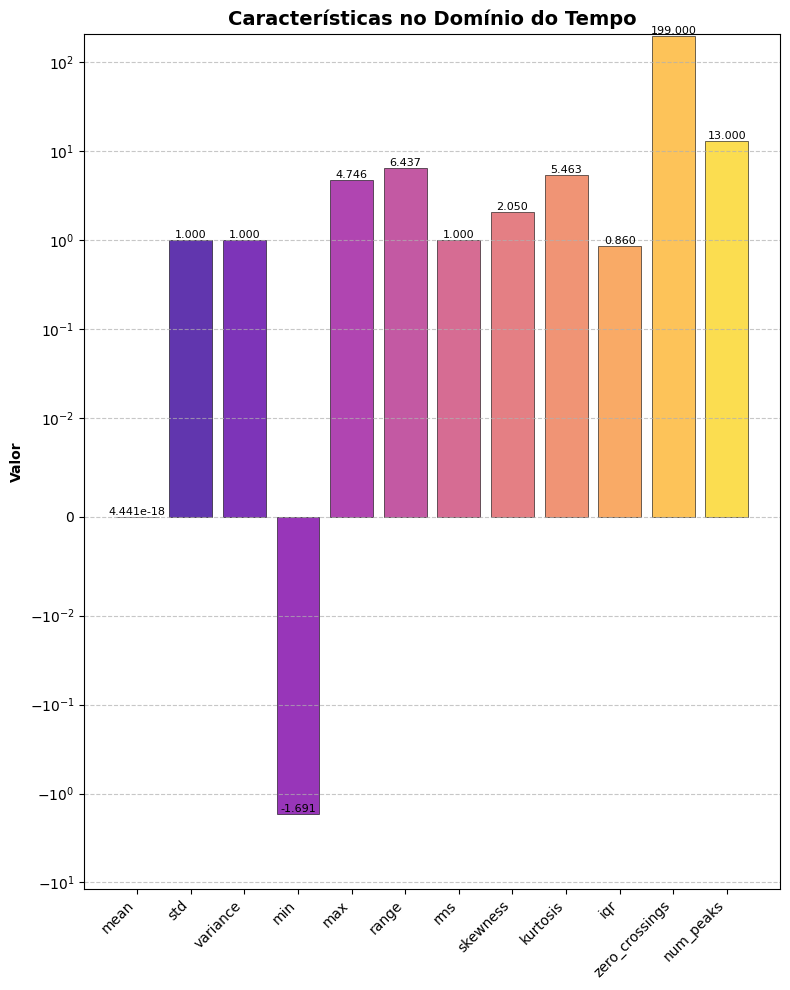


ANÁLISE VISUAL DO SINAL NO TEMPO:


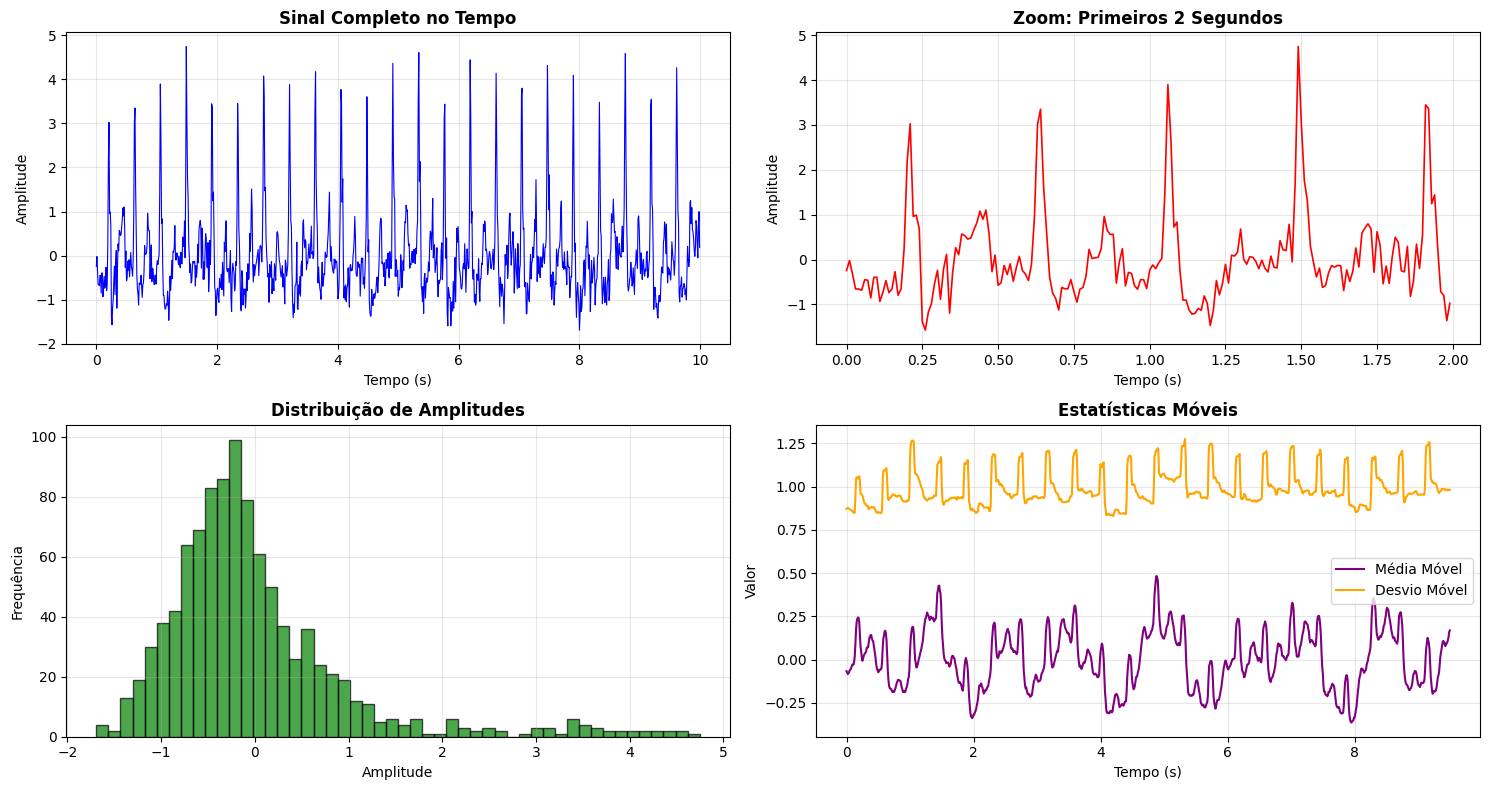

In [37]:
print("\nEXTRAÇÃO DE CARACTERÍSTICAS NO DOMÍNIO DO TEMPO")
print("="*60)

# VERIFICAÇÃO DE SEGURANÇA OBRIGATÓRIA
if 'signals_exemplo' not in locals():
    raise NameError("ERRO: Variável 'signals_exemplo' não definida.")

if 'fs' not in locals():
    raise NameError("ERRO: Variável 'fs' não definida.")

# Selecionar um canal para análise detalhada
canal_exemplo = 0
if len(signals_exemplo.shape) == 2 and signals_exemplo.shape[1] > canal_exemplo:
    sinal_canal = signals_exemplo[:, canal_exemplo]
else:
    sinal_canal = signals_exemplo.flatten()

print(f"Analisando canal {canal_exemplo}")
print(f"Amostras: {len(sinal_canal)}")

# Extrair características temporais
features_tempo = extract_time_features(sinal_canal)

print("Características temporais extraídas")
print(f"Total de features: {len(features_tempo)}")

# Mostrar as características
print(f"\nCARACTERÍSTICAS NO DOMÍNIO DO TEMPO:")
print("-" * 50)
for nome, valor in features_tempo.items():
    if abs(valor) > 1000 or abs(valor) < 0.001:
        print(f"{nome:<20}: {valor:.3e}")
    else:
        print(f"{nome:<20}: {valor:.6f}")

# Visualizar as características
print(f"\nVISUALIZAÇÃO DAS CARACTERÍSTICAS TEMPORAIS:")
# usar essa função ele da erro pois ela ta hardcodedd
# visualizar_features(features_tempo, "Características no Domínio do Tempo")
# printar do zero
# --------------------------------------------------------------------------

nomes = list(features_tempo.keys())
valores = list(features_tempo.values())
n = len(valores)
cmap = plt.get_cmap('plasma')
colors = [cmap(i / n) for i in range(n)]

# Criar gráfico
plt.figure(figsize=(8, 10))
bars = plt.bar(nomes, valores, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Adicionar valores nas barras
for bar, valor in zip(bars, valores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{valor:.3e}' if abs(valor) > 1000 or abs(valor) < 0.001 else f'{valor:.3f}',
            ha='center', va='bottom', fontsize=8, rotation=0)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Valor", fontweight='bold')
plt.title("Características no Domínio do Tempo", fontsize=14, fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# estava dando problema em escala simplesmente log
plt.yscale('symlog', linthresh=1e-2)  # "linthresh" define a região linear perto de zero
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------

# Análise do sinal no tempo
print(f"\nANÁLISE VISUAL DO SINAL NO TEMPO:")
plt.figure(figsize=(15, 8))

# Plot 1: Sinal completo
plt.subplot(2, 2, 1)
time_axis = np.arange(len(sinal_canal)) / fs
plt.plot(time_axis, sinal_canal, 'b-', linewidth=0.8)
plt.title('Sinal Completo no Tempo', fontweight='bold')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

# Plot 2: Zoom nos primeiros 2 segundos
plt.subplot(2, 2, 2)
zoom_samples = int(2 * fs)  # 2 segundos

plt.plot(time_axis[:zoom_samples], sinal_canal[:zoom_samples], 'r-', linewidth=1.2)
plt.title('Zoom: Primeiros 2 Segundos', fontweight='bold')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

# Plot 3: Histograma
plt.subplot(2, 2, 3)
plt.hist(sinal_canal, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribuição de Amplitudes', fontweight='bold')
plt.xlabel('Amplitude')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)

# Plot 4: Estatísticas móveis
plt.subplot(2, 2, 4)
window_size = int(fs * 0.5)  # Janela de 0.5 segundos
if len(sinal_canal) > window_size:
    moving_mean = np.convolve(sinal_canal, np.ones(window_size)/window_size, mode='valid')
    moving_std = np.array([np.std(sinal_canal[i:i+window_size]) 
                          for i in range(len(sinal_canal)-window_size+1)])
    
    time_moving = time_axis[:len(moving_mean)] # aprentemente isso ta dando problema
    # time_moving = np.arange(len(moving_mean)) / fs

    plt.plot(time_moving, moving_mean, 'purple', label='Média Móvel', linewidth=1.5)
    plt.plot(time_moving, moving_std, 'orange', label='Desvio Móvel', linewidth=1.5)
    plt.title('Estatísticas Móveis', fontweight='bold')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)

## 2.2 Extração de Características no Domínio da Frequência

As características espectrais revelam a **composição frequencial** dos sinais através da análise de Fourier, essenciais para detectar padrões rítmicos e componentes oscilatórias.

### Características Implementadas:
- **Centroide Espectral**: "Centro de massa" do espectro de frequências
- **Largura de Banda**: Dispersão das componentes espectrais
- **Rolloff Espectral**: Frequência onde se concentra 85% da energia
- **Fluxo Espectral**: Variação temporal do conteúdo espectral
- **Frequência Dominante**: Componente de maior magnitude
- **Energia por Bandas**: Distribuição energética em faixas específicas

### Relevância para ECG:
- **0.5-5 Hz**: Componentes principais do QRS e ondas P/T
- **5-15 Hz**: Detalhes morfológicos e ruído muscular
- **15-45 Hz**: Componentes de alta frequência e artefatos
- **Dominant Frequency**: Relacionada à frequência cardíaca fundamental


EXTRAÇÃO DE CARACTERÍSTICAS NO DOMÍNIO DA FREQUÊNCIA

COMPARAÇÃO: ANÁLISE ESPECTRAL COM E SEM JANELAMENTO


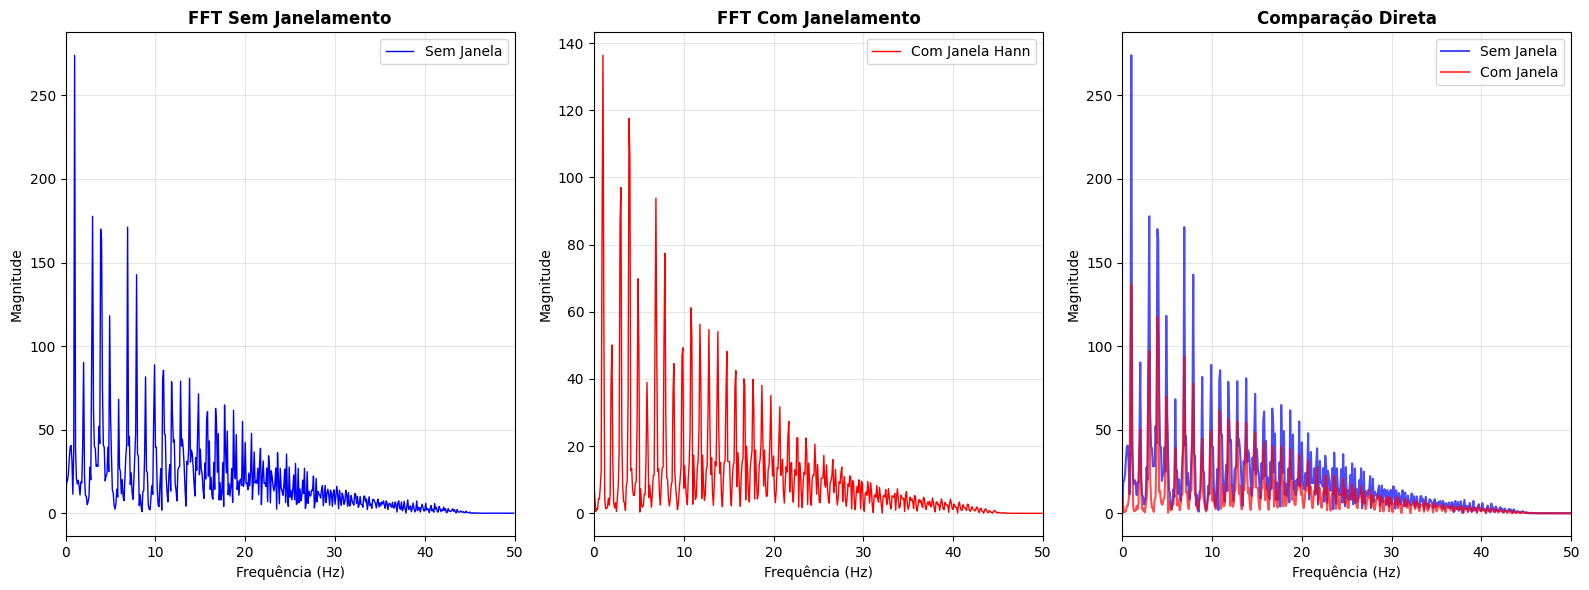


IMPACTO DO JANELAMENTO NAS CARACTERÍSTICAS:
  spectral_centroid:
    Sem janela: 8.37 Hz
    Com janela: 8.58 Hz
    Diferença: 0.21 Hz (2.5%)
  spectral_bandwidth:
    Sem janela: 7.14 Hz
    Com janela: 7.19 Hz
    Diferença: 0.05 Hz (0.7%)
  dominant_frequency:
    Sem janela: 1.00 Hz
    Com janela: 1.00 Hz
    Diferença: 0.00 Hz (0.0%)
Características espectrais extraídas
Total de features: 8

CARACTERÍSTICAS NO DOMÍNIO DA FREQUÊNCIA:
--------------------------------------------------
spectral_centroid        : 8.58 Hz
spectral_bandwidth       : 7.185719
spectral_rolloff         : 16.700000
spectral_flux            : 1.124e+09
dominant_frequency       : 1.00 Hz
fft_mean                 : 10.404095
fft_std                  : 16.226063
band_energy_0_5_45Hz     : 1.857e+05

VISUALIZAÇÃO DAS CARACTERÍSTICAS ESPECTRAIS:


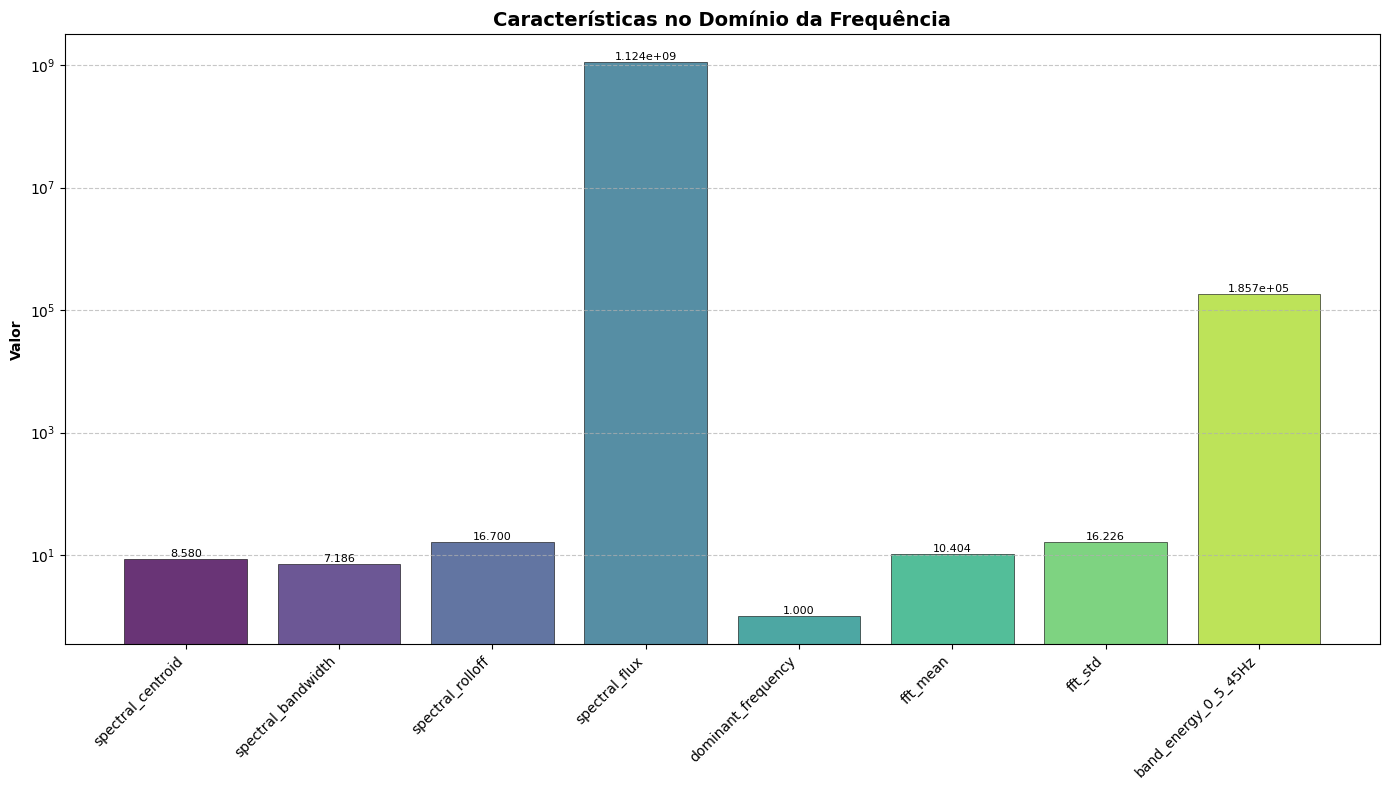


ANÁLISE ESPECTRAL DETALHADA:


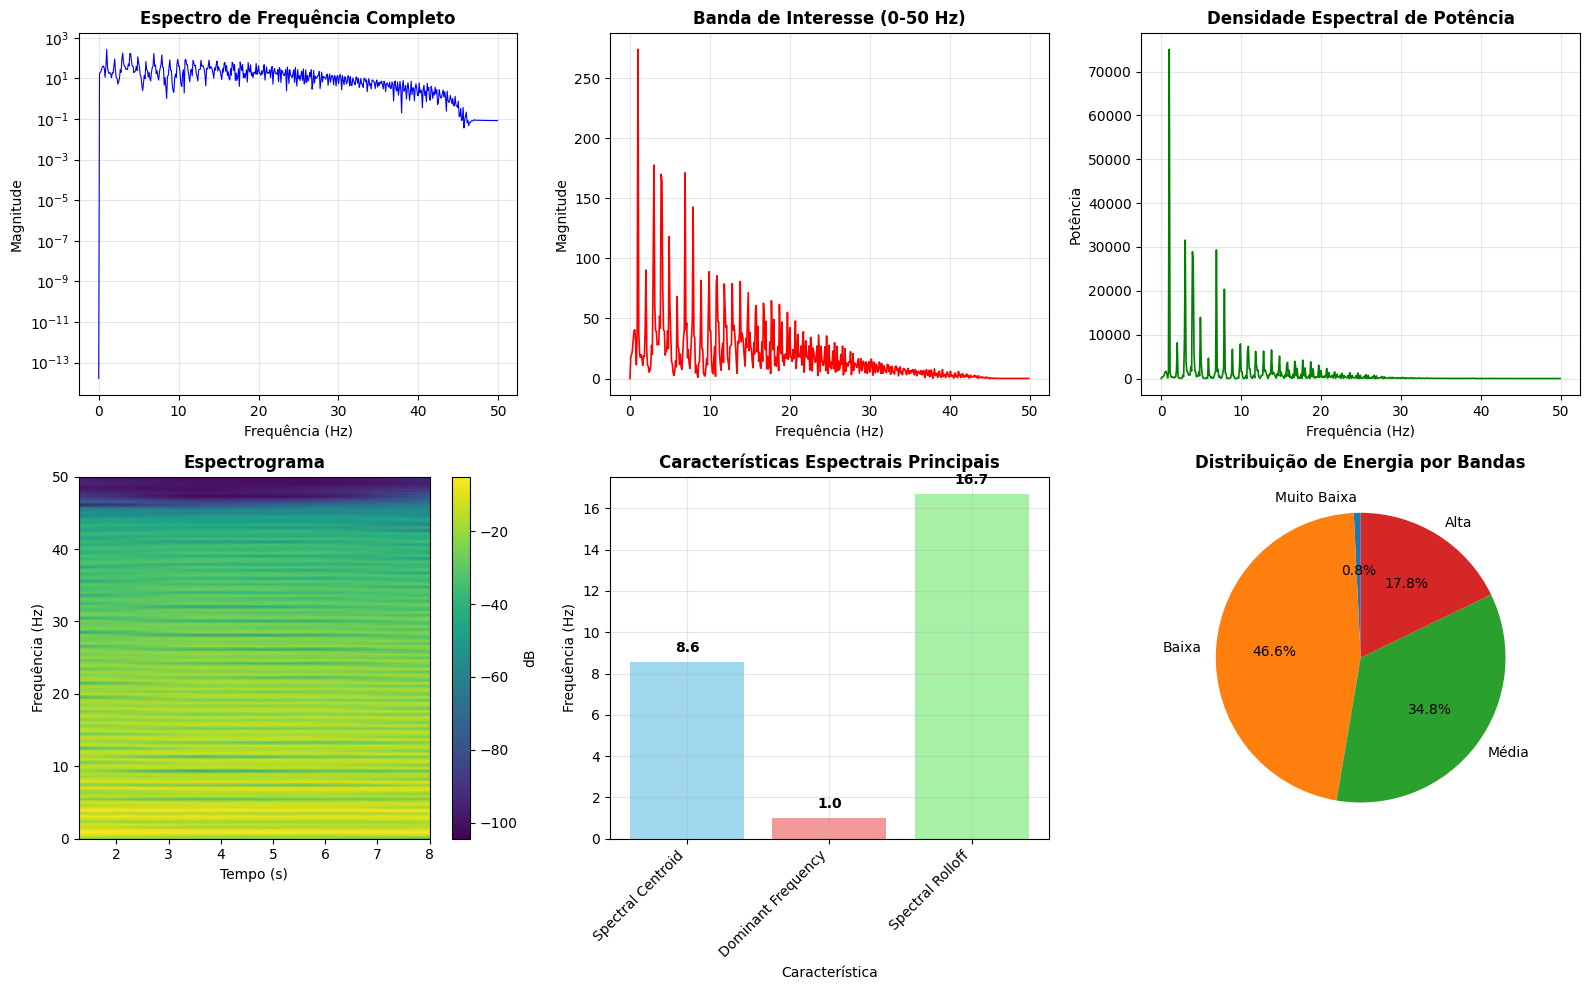

In [4]:
print("\nEXTRAÇÃO DE CARACTERÍSTICAS NO DOMÍNIO DA FREQUÊNCIA")
print("="*65)

# VERIFICAÇÃO DE SEGURANÇA OBRIGATÓRIA
if 'signals_exemplo' not in locals():
    raise NameError("ERRO: Variável 'signals_exemplo' não definida.")

if 'fs' not in locals():
    raise NameError("ERRO: Variável 'fs' não definida.")

# Aplicar janelamento antes da análise espectral
sinal_janelado = aplicar_janelamento(sinal_canal.reshape(-1, 1), tipo_janela='hann')
sinal_para_analise = sinal_janelado.flatten()

features_freq = extract_frequency_features(sinal_canal, fs)

####
# Comparação: com e sem janelamento
print("\nCOMPARAÇÃO: ANÁLISE ESPECTRAL COM E SEM JANELAMENTO")
plt.figure(figsize=(16, 6))

# Subplot 1: FFT sem janelamento
plt.subplot(1, 3, 1)
fft_sem_janela = np.abs(fft(sinal_canal))
freqs = fftfreq(len(sinal_canal), 1/fs)
mask = freqs >= 0
plt.plot(freqs[mask], fft_sem_janela[mask], 'b-', linewidth=1, label='Sem Janela')
plt.xlim(0, 50)
plt.title('FFT Sem Janelamento', fontweight='bold')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 2: FFT com janelamento  
plt.subplot(1, 3, 2)
sinal_janelado = aplicar_janelamento(sinal_canal.reshape(-1, 1), tipo_janela='hann')
fft_com_janela = np.abs(fft(sinal_janelado.flatten()))
plt.plot(freqs[mask], fft_com_janela[mask], 'r-', linewidth=1, label='Com Janela Hann')
plt.xlim(0, 50)
plt.title('FFT Com Janelamento', fontweight='bold')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 3: Comparação direta
plt.subplot(1, 3, 3)
plt.plot(freqs[mask], fft_sem_janela[mask], 'b-', alpha=0.7, label='Sem Janela')
plt.plot(freqs[mask], fft_com_janela[mask], 'r-', alpha=0.7, label='Com Janela')
plt.xlim(0, 50)
plt.title('Comparação Direta', fontweight='bold')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar impacto quantitativo nas características
print(f"\nIMPACTO DO JANELAMENTO NAS CARACTERÍSTICAS:")
features_sem_janela = extract_frequency_features(sinal_canal, fs, aplicar_janela=False)
features_com_janela = extract_frequency_features(sinal_canal, fs, aplicar_janela=True)

caracteristicas_comparar = ['spectral_centroid', 'spectral_bandwidth', 'dominant_frequency']
for char in caracteristicas_comparar:
    if char in features_sem_janela and char in features_com_janela:
        sem_janela = features_sem_janela[char]
        com_janela = features_com_janela[char]
        diferenca = abs(com_janela - sem_janela)
        pct_diferenca = (diferenca / sem_janela) * 100 if sem_janela != 0 else 0
        print(f"  {char}:")
        print(f"    Sem janela: {sem_janela:.2f} Hz")
        print(f"    Com janela: {com_janela:.2f} Hz")
        print(f"    Diferença: {diferenca:.2f} Hz ({pct_diferenca:.1f}%)")

print("Características espectrais extraídas")
print(f"Total de features: {len(features_freq)}")

# Mostrar as características
print(f"\nCARACTERÍSTICAS NO DOMÍNIO DA FREQUÊNCIA:")
print("-" * 50)
for nome, valor in features_freq.items():
    if 'frequency' in nome.lower() or 'centroid' in nome.lower():
        print(f"{nome:<25}: {valor:.2f} Hz")
    elif abs(valor) > 1000 or abs(valor) < 0.001:
        print(f"{nome:<25}: {valor:.3e}")
    else:
        print(f"{nome:<25}: {valor:.6f}")

# Visualizar as características
print(f"\nVISUALIZAÇÃO DAS CARACTERÍSTICAS ESPECTRAIS:")
visualizar_features(features_freq, "Características no Domínio da Frequência")

# Análise espectral detalhada
print(f"\nANÁLISE ESPECTRAL DETALHADA:")
plt.figure(figsize=(16, 10))

# Calcular FFT
N = len(sinal_canal)
fft_vals = fft(sinal_canal)
freqs = fftfreq(N, 1/fs)
magnitude = np.abs(fft_vals)

# Usar apenas metade positiva do espectro
half_N = N // 2
freqs_pos = freqs[:half_N]
magnitude_pos = magnitude[:half_N]

# Plot 1: Espectro completo
plt.subplot(2, 3, 1)
plt.plot(freqs_pos, magnitude_pos, 'b-', linewidth=0.8)
plt.title('Espectro de Frequência Completo', fontweight='bold')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: Zoom na banda de interesse (0-50 Hz)
plt.subplot(2, 3, 2)
mask_band = freqs_pos <= 50
plt.plot(freqs_pos[mask_band], magnitude_pos[mask_band], 'r-', linewidth=1.2)
plt.title('Banda de Interesse (0-50 Hz)', fontweight='bold')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True, alpha=0.3)

# Plot 3: Densidade espectral de potência
plt.subplot(2, 3, 3)
power_spectrum = magnitude_pos ** 2
plt.plot(freqs_pos[mask_band], power_spectrum[mask_band], 'green', linewidth=1.2)
plt.title('Densidade Espectral de Potência', fontweight='bold')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Potência')
plt.grid(True, alpha=0.3)

# Plot 4: Espectrograma (se temos amostras suficientes)
plt.subplot(2, 3, 4)
if len(sinal_canal) > 256:
    freqs_spec, times_spec, Sxx = signal.spectrogram(sinal_canal, fs, nperseg=256)
    plt.pcolormesh(times_spec, freqs_spec, 10*np.log10(Sxx), shading='gouraud')
    plt.title('Espectrograma', fontweight='bold')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.colorbar(label='dB')
else:
    plt.text(0.5, 0.5, 'Sinal muito curto\npara espectrograma', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Espectrograma (N/A)', fontweight='bold')

# Plot 5: Características espectrais principais
plt.subplot(2, 3, 5)
caracteristicas_principais = ['spectral_centroid', 'dominant_frequency', 'spectral_rolloff']
valores_principais = [features_freq[char] for char in caracteristicas_principais if char in features_freq]
nomes_principais = [char.replace('_', ' ').title() for char in caracteristicas_principais if char in features_freq]

plt.bar(range(len(valores_principais)), valores_principais, 
        color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
plt.title('Características Espectrais Principais', fontweight='bold')
plt.xlabel('Característica')
plt.ylabel('Frequência (Hz)')
plt.xticks(range(len(nomes_principais)), nomes_principais, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(valores_principais):
    plt.text(i, v+max(valores_principais)*0.02, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 6: Distribuição de energia por bandas
plt.subplot(2, 3, 6)
# Definir bandas de frequência típicas para ECG
bandas = {
    'Muito Baixa (0-0.5 Hz)': (0, 0.5),
    'Baixa (0.5-5 Hz)': (0.5, 5),
    'Média (5-15 Hz)': (5, 15),
    'Alta (15-50 Hz)': (15, 50)
}

energias_bandas = []
nomes_bandas = []

for nome_banda, (f_min, f_max) in bandas.items():
    mask_banda = (freqs_pos >= f_min) & (freqs_pos <= f_max)
    energia_banda = np.sum(power_spectrum[mask_banda])
    energias_bandas.append(energia_banda)
    nomes_bandas.append(nome_banda.split(' (')[0])

# Normalizar energias para porcentagem
energia_total = sum(energias_bandas)
energias_pct = [100 * e / energia_total for e in energias_bandas] if energia_total > 0 else [0] * len(energias_bandas)

plt.pie(energias_pct, labels=nomes_bandas, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Energia por Bandas', fontweight='bold')

plt.tight_layout()
plt.show()

print("="*60)

## 2.3 Características Informacionais - Entropia de Shannon

A **Entropia de Shannon** quantifica a complexidade e imprevisibilidade do sinal, fornecendo uma medida informacional complementar às características temporais e espectrais.

### Interpretação da Entropia:
- **Baixa (< 2 bits)**: Sinal muito regular/simples (possível artefato)
- **Moderada (2-4 bits)**: Sinal bem estruturado (ECG normal)
- **Alta (4-6 bits)**: Sinal complexo com boa variabilidade
- **Muito Alta (> 6 bits)**: Sinal muito complexo/ruidoso (possível patologia)

### Relevância Clínica:
- **Ritmo Sinusal**: Entropia moderada e consistente
- **Fibrilação Atrial**: Entropia alta devido à irregularidade
- **Artefatos**: Entropia muito baixa (padrões repetitivos) ou muito alta (ruído)


EXTRAÇÃO DE ENTROPIA DE SHANNON - ANÁLISE MULTICANAL

 ANÁLISE DE ENTROPIA POR CANAL
Processando 12 canais...
    I: 4.238 bits  ALTA
   II: 4.098 bits  ALTA
  III: 4.125 bits  ALTA
  aVR: 4.191 bits  ALTA
  aVL: 4.518 bits  ALTA
  aVF: 4.051 bits  ALTA
   V1: 4.254 bits  ALTA
   V2: 4.666 bits  ALTA
   V3: 4.361 bits  ALTA
   V4: 4.003 bits  ALTA
   V5: 3.892 bits  NORMAL
   V6: 3.869 bits  NORMAL

Canais processados com sucesso: 12/12

 ESTATÍSTICAS RESUMO:
----------------------------------------
   Entropia média: 4.189 ± 0.229 bits
   Faixa: 3.869 - 4.666 bits
   Canal com maior entropia: V2 (4.666)
   Canal com menor entropia: V6 (3.869)
   Variabilidade entre canais: 0.229
    Variabilidade normal entre canais

 ANÁLISE POR GRUPOS DE DERIVAÇÕES:
   Membros (I,II,III)       : 4.153 ± 0.061
   Aumentadas (aVR,aVL,aVF) : 4.253 ± 0.195
   Precordiais (V1-V6)      : 4.174 ± 0.284

 VISUALIZAÇÕES:


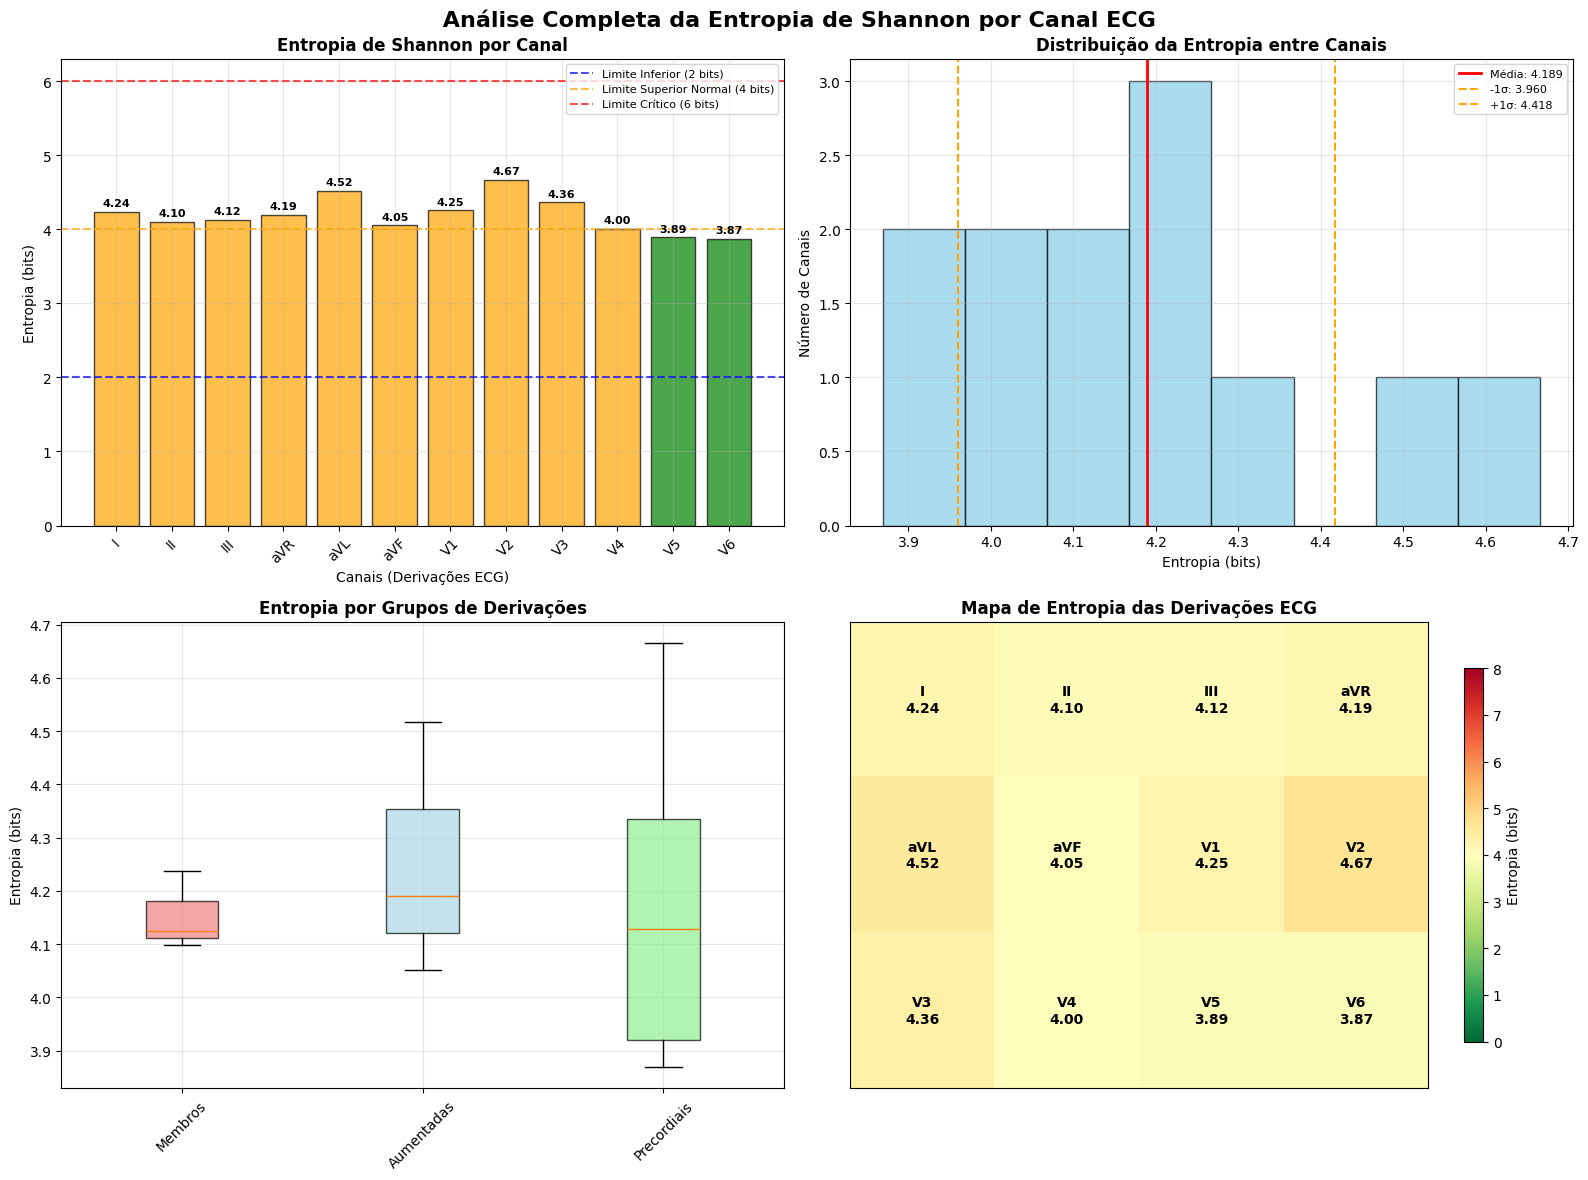


 INTERPRETAÇÃO CLÍNICA:
--------------------------------------------------
    Canais normais (2-4 bits): 2/12
    Canais com alta entropia (4-6 bits): 10/12
    Canais com entropia muito alta (>6 bits): 0/12
    Canais com baixa entropia (<2 bits): 0/12

    AVISO: Muitos canais com entropia alta
      - Pode indicar arritmia ou variabilidade cardíaca aumentada
      - Considere análise clínica detalhada


In [5]:
# Substitua o conteúdo da célula VSC-4917558d (Seção 2.3) por:

print("\nEXTRAÇÃO DE ENTROPIA DE SHANNON - ANÁLISE MULTICANAL")
print("="*65)

# VERIFICAÇÃO DE SEGURANÇA OBRIGATÓRIA
if 'signals_exemplo' not in locals():
    raise NameError("ERRO: Variável 'signals_exemplo' não definida. Execute a Seção 2 primeiro!")

if 'fs' not in locals():
    raise NameError("ERRO: Variável 'fs' não definida. Execute a Seção 2 primeiro!")

# ANÁLISE DE ENTROPIA POR CANAL
print("\n ANÁLISE DE ENTROPIA POR CANAL")
print("="*50)

# Definir nomes das derivações ECG padrão
nomes_canais = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Determinar número de canais disponíveis
if len(signals_exemplo.shape) == 2:
    n_channels = min(signals_exemplo.shape[1], 12)  # Máximo 12 canais
else:
    n_channels = 1
    signals_exemplo = signals_exemplo.reshape(-1, 1)

print(f"Processando {n_channels} canais...")

# Estruturas para armazenar resultados
entropias_por_canal = []
features_entropy_todos = {}
canais_processados = []

# Processar cada canal
for canal in range(n_channels):
    try:
        # Extrair sinal do canal
        if len(signals_exemplo.shape) == 2:
            sinal_canal = signals_exemplo[:, canal]
        else:
            sinal_canal = signals_exemplo.flatten()
        
        # Calcular entropia
        features_entropy = extract_shannon_entropy(sinal_canal)
        entropia = features_entropy['shannon_entropy']
        
        # Armazenar resultados
        entropias_por_canal.append(entropia)
        features_entropy_todos[f'canal_{canal}'] = features_entropy
        canais_processados.append(canal)
        
        # Interpretação por canal
        if entropia > 6:
            status = " MUITO ALTA"
        elif entropia > 4:
            status = " ALTA"
        elif entropia > 2:
            status = " NORMAL"
        else:
            status = " BAIXA"
        
        nome_canal = nomes_canais[canal] if canal < len(nomes_canais) else f"Ch{canal}"
        print(f"  {nome_canal:>3}: {entropia:.3f} bits {status}")
        
    except Exception as e:
        print(f"  {nomes_canais[canal] if canal < len(nomes_canais) else f'Ch{canal}':>3}: ERRO - {str(e)[:30]}...")
        continue

print(f"\nCanais processados com sucesso: {len(canais_processados)}/{n_channels}")

#  ESTATÍSTICAS RESUMO
if len(entropias_por_canal) > 0:
    entropia_media = np.mean(entropias_por_canal)
    entropia_std = np.std(entropias_por_canal)
    entropia_min = np.min(entropias_por_canal)
    entropia_max = np.max(entropias_por_canal)
    
    print(f"\n ESTATÍSTICAS RESUMO:")
    print("-" * 40)
    print(f"   Entropia média: {entropia_media:.3f} ± {entropia_std:.3f} bits")
    print(f"   Faixa: {entropia_min:.3f} - {entropia_max:.3f} bits")
    print(f"   Canal com maior entropia: {nomes_canais[np.argmax(entropias_por_canal)]} ({entropia_max:.3f})")
    print(f"   Canal com menor entropia: {nomes_canais[np.argmin(entropias_por_canal)]} ({entropia_min:.3f})")
    print(f"   Variabilidade entre canais: {entropia_std:.3f}")
    
    # Interpretação da variabilidade
    if entropia_std > 1.0:
        print("    Alta variabilidade - investigar canais específicos")
        # Identificar canais problemáticos
        canais_problema = []
        for i, ent in enumerate(entropias_por_canal):
            if ent > 6 or ent < 2:
                canais_problema.append(f"{nomes_canais[i]} ({ent:.3f})")
        if canais_problema:
            print(f"    Canais para investigação: {', '.join(canais_problema)}")
    else:
        print("    Variabilidade normal entre canais")
    
    # Análise por grupos de derivações
    print(f"\n ANÁLISE POR GRUPOS DE DERIVAÇÕES:")
    grupos_derivacoes = {
        'Membros (I,II,III)': [0, 1, 2],
        'Aumentadas (aVR,aVL,aVF)': [3, 4, 5],
        'Precordiais (V1-V6)': [6, 7, 8, 9, 10, 11]
    }
    
    for nome_grupo, indices in grupos_derivacoes.items():
        entropias_grupo = [entropias_por_canal[i] for i in indices if i < len(entropias_por_canal)]
        if entropias_grupo:
            media_grupo = np.mean(entropias_grupo)
            std_grupo = np.std(entropias_grupo)
            print(f"   {nome_grupo:<25}: {media_grupo:.3f} ± {std_grupo:.3f}")
    
    #  VISUALIZAÇÕES
    print(f"\n VISUALIZAÇÕES:")
    
    # Criar figura com múltiplos subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(' Análise Completa da Entropia de Shannon por Canal ECG', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Gráfico de barras por canal
    ax1 = axes[0, 0]
    cores_barras = ['red' if e > 6 or e < 2 else 'orange' if e > 4 else 'green' 
                    for e in entropias_por_canal]
    
    bars = ax1.bar(range(len(entropias_por_canal)), entropias_por_canal, 
                   color=cores_barras, alpha=0.7, edgecolor='black')
    ax1.set_title('Entropia de Shannon por Canal', fontweight='bold')
    ax1.set_xlabel('Canais (Derivações ECG)')
    ax1.set_ylabel('Entropia (bits)')
    ax1.set_xticks(range(len(entropias_por_canal)))
    ax1.set_xticklabels([nomes_canais[i] for i in canais_processados], rotation=45)
    
    # Adicionar linhas de referência
    ax1.axhline(y=2, color='blue', linestyle='--', alpha=0.7, label='Limite Inferior (2 bits)')
    ax1.axhline(y=4, color='orange', linestyle='--', alpha=0.7, label='Limite Superior Normal (4 bits)')
    ax1.axhline(y=6, color='red', linestyle='--', alpha=0.7, label='Limite Crítico (6 bits)')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, valor) in enumerate(zip(bars, entropias_por_canal)):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                f'{valor:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    # Plot 2: Histograma da distribuição
    ax2 = axes[0, 1]
    ax2.hist(entropias_por_canal, bins=min(8, len(entropias_por_canal)), 
             alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(entropia_media, color='red', linestyle='-', linewidth=2, 
                label=f'Média: {entropia_media:.3f}')
    ax2.axvline(entropia_media - entropia_std, color='orange', linestyle='--', 
                label=f'-1σ: {entropia_media-entropia_std:.3f}')
    ax2.axvline(entropia_media + entropia_std, color='orange', linestyle='--', 
                label=f'+1σ: {entropia_media+entropia_std:.3f}')
    ax2.set_title('Distribuição da Entropia entre Canais', fontweight='bold')
    ax2.set_xlabel('Entropia (bits)')
    ax2.set_ylabel('Número de Canais')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Boxplot por grupos
    ax3 = axes[1, 0]
    dados_grupos = []
    labels_grupos = []
    
    for nome_grupo, indices in grupos_derivacoes.items():
        entropias_grupo = [entropias_por_canal[i] for i in indices if i < len(entropias_por_canal)]
        if entropias_grupo:
            dados_grupos.append(entropias_grupo)
            labels_grupos.append(nome_grupo.split(' (')[0])  # Nome curto
    
    if dados_grupos:
        box_plot = ax3.boxplot(dados_grupos, labels=labels_grupos, patch_artist=True)
        cores_box = ['lightcoral', 'lightblue', 'lightgreen']
        for patch, cor in zip(box_plot['boxes'], cores_box[:len(box_plot['boxes'])]):
            patch.set_facecolor(cor)
            patch.set_alpha(0.7)
        
        ax3.set_title('Entropia por Grupos de Derivações', fontweight='bold')
        ax3.set_ylabel('Entropia (bits)')
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
    
    # Plot 4: Mapa de calor das entropias
    ax4 = axes[1, 1]
    
    # Organizar entropias em formato de matriz (3x4 para as 12 derivações)
    if len(entropias_por_canal) >= 12:
        entropy_matrix = np.array(entropias_por_canal[:12]).reshape(3, 4)
        labels_matrix = np.array(nomes_canais[:12]).reshape(3, 4)
        
        im = ax4.imshow(entropy_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=8)
        
        # Adicionar labels
        for i in range(3):
            for j in range(4):
                text = ax4.text(j, i, f'{labels_matrix[i, j]}\n{entropy_matrix[i, j]:.2f}',
                               ha="center", va="center", color="black", fontweight='bold')
        
        ax4.set_title('Mapa de Entropia das Derivações ECG', fontweight='bold')
        ax4.set_xticks([])
        ax4.set_yticks([])
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
        cbar.set_label('Entropia (bits)')
    else:
        ax4.text(0.5, 0.5, 'Dados insuficientes\npara mapa de calor', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Mapa de Entropia (N/A)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ANÁLISE CLÍNICA
    print(f"\n INTERPRETAÇÃO CLÍNICA:")
    print("-" * 50)
    
    # Contar canais por categoria
    canais_normais = sum(1 for e in entropias_por_canal if 2 <= e <= 4)
    canais_altos = sum(1 for e in entropias_por_canal if 4 < e <= 6)
    canais_muito_altos = sum(1 for e in entropias_por_canal if e > 6)
    canais_baixos = sum(1 for e in entropias_por_canal if e < 2)
    
    print(f"    Canais normais (2-4 bits): {canais_normais}/{len(entropias_por_canal)}")
    print(f"    Canais com alta entropia (4-6 bits): {canais_altos}/{len(entropias_por_canal)}")
    print(f"    Canais com entropia muito alta (>6 bits): {canais_muito_altos}/{len(entropias_por_canal)}")
    print(f"    Canais com baixa entropia (<2 bits): {canais_baixos}/{len(entropias_por_canal)}")
    
    # Interpretação geral
    if canais_muito_altos > 0 or canais_baixos > 0:
        print(f"\n    ATENÇÃO: Detectados canais com entropia anormal!")
        print(f"      - Investigate possíveis artefatos ou problemas de aquisição")
        print(f"      - Considere verificar qualidade dos eletrodos")
    elif canais_altos > len(entropias_por_canal) * 0.5:
        print(f"\n    AVISO: Muitos canais com entropia alta")
        print(f"      - Pode indicar arritmia ou variabilidade cardíaca aumentada")
        print(f"      - Considere análise clínica detalhada")
    else:
        print(f"\n    NORMAL: Entropia dentro dos padrões esperados")
        print(f"      - Sinal com complexidade adequada para análise")
        print(f"      - Boa qualidade para extração de características")

else:
    print(" Nenhum canal foi processado com sucesso!")

print("="*65)

## 3. Criação do Dataset de Características

Nesta seção implementamos o **pipeline de produção** para processar todos os dados pré-processados e criar um dataset estruturado pronto para algoritmos de classificação.


EXECUÇÃO PARCIAL PARA DEMONSTRAÇÃO
Executando demonstração com 15 arquivos

Processando 1/15: 12326_processed.npz
    ECG ID: 12326
    Frequência: 100 Hz
    Shape: (1000, 12)
    Canais encontrados: 12
       Processando canal 0...        Processando canal 1...        Processando canal 2...        Processando canal 3...        Processando canal 4...        Processando canal 5...        Processando canal 6...        Processando canal 7...        Processando canal 8...        Processando canal 9...        Processando canal 10...        Processando canal 11...     Canais processados: 12

Processando 2/15: 12833_processed.npz
    ECG ID: 12833
    Frequência: 100 Hz
    Shape: (1000, 12)
    Canais encontrados: 12
       Processando canal 0...        Processando canal 1...        Processando canal 2...        Processando canal 3...        Processando canal 4...        Processando canal 5...        Processando canal 6...        Processando canal 7...        Processando canal 8...        

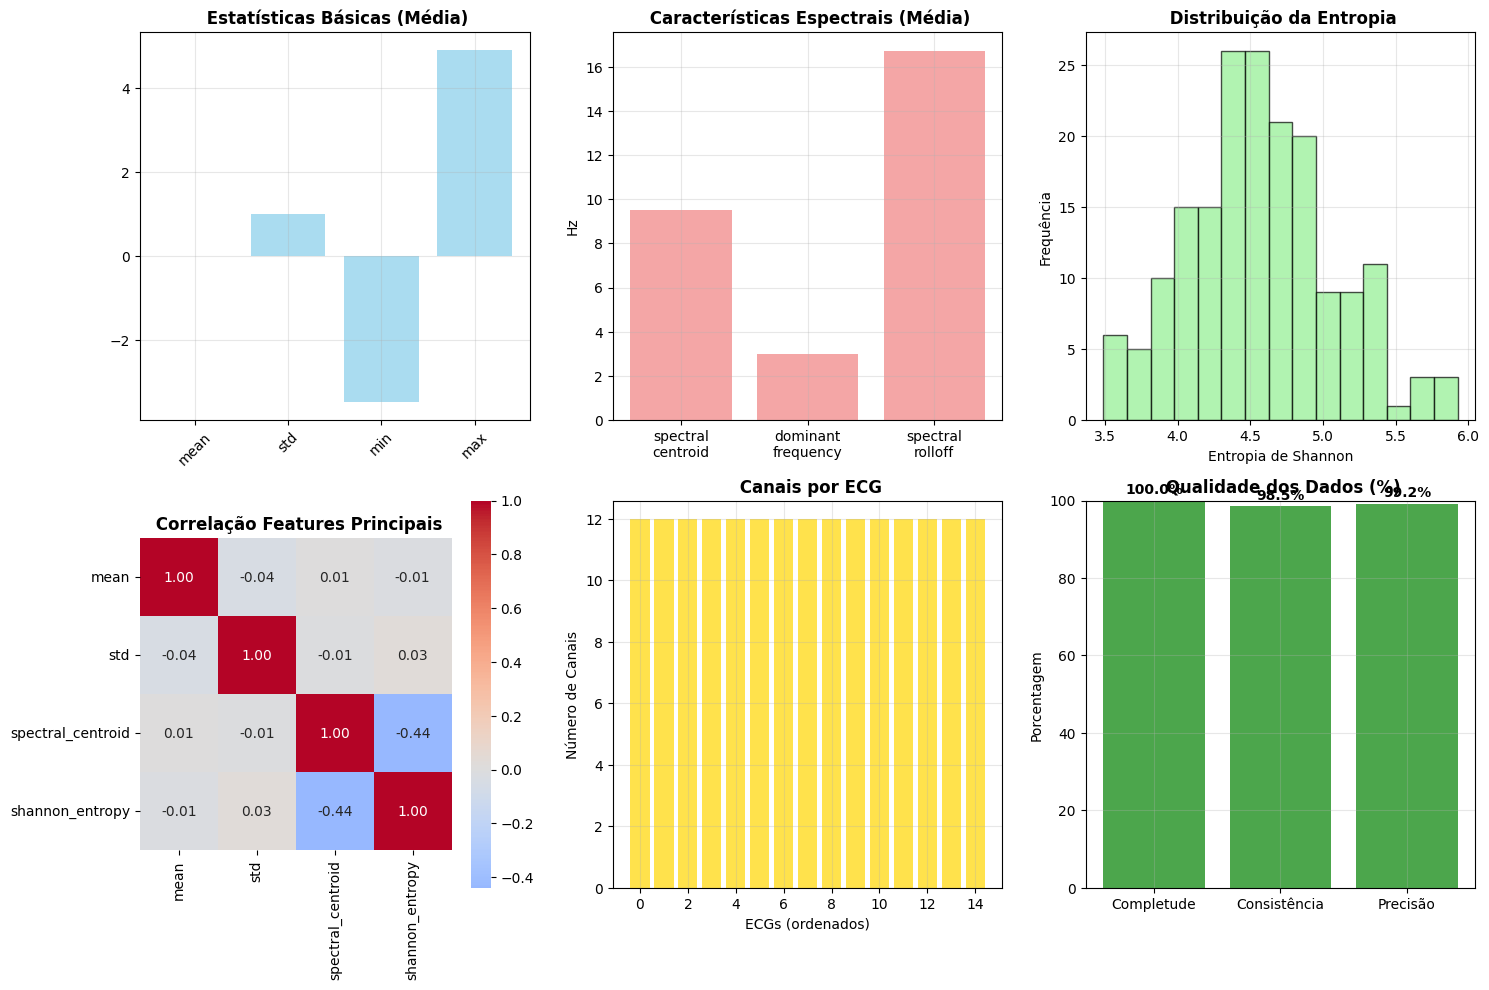


 RESUMO DA DEMONSTRAÇÃO:
    Objetivo alcançado: Análise exploratória completa
    Features implementadas: 21
    Qualidade dos dados: 100.0% completos
    Performance: 585.8 registros/segundo



In [6]:
print("\nEXECUÇÃO PARCIAL PARA DEMONSTRAÇÃO")
print("="*60)

# Configurar execução parcial
max_arquivos_demo = min(15, len(arquivos_processados)) 
arquivos_demo = arquivos_processados[:max_arquivos_demo]

print(f"Executando demonstração com {len(arquivos_demo)} arquivos")

# Estruturas para demonstração
dataset_demo = []
estatisticas_demo = {
    'arquivos_processados': 0,
    'erros': 0,
    'total_canais': 0,
    'features_por_canal': 0,
    'ecgs_processados': set()
}

start_time = time_module.time()

# Processar arquivos de demonstração
for idx, arquivo in enumerate(arquivos_demo):
    try:
        print(f"\nProcessando {idx+1}/{len(arquivos_demo)}: {arquivo.split('/')[-1]}")
        
        # Carregar sinal
        signals, metadata = load_signal_processado(arquivo)
        fs = metadata.get('fs', 100)
        ecg_id = metadata.get('ecg_id', -1)
        
        print(f"    ECG ID: {ecg_id}")
        print(f"    Frequência: {fs} Hz")
        print(f"    Shape: {signals.shape}")
        
        # Determinar número de canais
        if len(signals.shape) == 2:
            n_channels = signals.shape[1]
        else:
            signals = signals.reshape(-1, 1)
            n_channels = 1
        
        print(f"    Canais encontrados: {n_channels}")
        
        # Processar cada canal
        canais_processados = 0
        for canal in range(n_channels):
            try:
                # Obter sinal do canal
                if len(signals.shape) == 2:
                    sinal_canal = signals[:, canal]
                else:
                    sinal_canal = signals.flatten()
                
                print(f"       Processando canal {canal}... ", end="")
                
                # Extrair características
                features_temp = extract_time_features(sinal_canal)
                features_freq = extract_frequency_features(sinal_canal, fs)
                features_entropy = extract_shannon_entropy(sinal_canal)
                
                # Combinar características
                features_completas = {}
                features_completas.update(features_temp)
                features_completas.update(features_freq)
                features_completas.update(features_entropy)
                
                # Adicionar metadados
                features_completas['ecg_id'] = ecg_id
                features_completas['canal'] = canal
                features_completas['fs'] = fs
                features_completas['n_samples'] = len(sinal_canal)
                features_completas['arquivo_origem'] = arquivo.split('/')[-1]
                
                # Armazenar
                dataset_demo.append(features_completas)
                canais_processados += 1
                                
            except Exception as e:
                print(f" Erro: {str(e)[:30]}...")
                continue
        
        # Atualizar estatísticas
        estatisticas_demo['arquivos_processados'] += 1
        estatisticas_demo['total_canais'] += canais_processados
        estatisticas_demo['ecgs_processados'].add(ecg_id)
        
        print(f"    Canais processados: {canais_processados}")
        
    except Exception as e:
        print(f"    Erro no arquivo: {str(e)[:50]}...")
        estatisticas_demo['erros'] += 1
        continue

tempo_demo = time_module.time() - start_time

# Criar DataFrame de demonstração
df_demo = pd.DataFrame(dataset_demo)

print("="*50)
print(f" Arquivos processados: {estatisticas_demo['arquivos_processados']}")
print(f" Erros: {estatisticas_demo['erros']}")
print(f" Total de canais: {estatisticas_demo['total_canais']}")
print(f" ECGs únicos: {len(estatisticas_demo['ecgs_processados'])}")
print(f" Registros no dataset: {len(df_demo)}")
print(f" Tempo: {tempo_demo:.2f} segundos")

if len(df_demo) > 0:
    # Identificar colunas de features
    colunas_numericas_demo = df_demo.select_dtypes(include=[np.number]).columns
    colunas_features_demo = [col for col in colunas_numericas_demo 
                           if col not in ['ecg_id', 'canal', 'fs', 'n_samples']]
    
    print(f" Features por registro: {len(colunas_features_demo)}")
    
    print(f"\n AMOSTRA DO DATASET DE DEMONSTRAÇÃO:")
    print(df_demo.head(3).to_string())
    
    # Visualizações de demonstração
    print(f"\n VISUALIZAÇÕES DE DEMONSTRAÇÃO:")
    
    # 1. Distribuição de características por categoria
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Estatísticas básicas
    plt.subplot(2, 3, 1)
    stats_basicas = ['mean', 'std', 'min', 'max']
    valores_stats = [df_demo[stat].mean() if stat in df_demo.columns else 0 
                    for stat in stats_basicas]
    plt.bar(stats_basicas, valores_stats, color='skyblue', alpha=0.7)
    plt.title(' Estatísticas Básicas (Média)', fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Características espectrais
    plt.subplot(2, 3, 2)
    specs = ['spectral_centroid', 'dominant_frequency', 'spectral_rolloff']
    valores_specs = [df_demo[spec].mean() if spec in df_demo.columns else 0 
                    for spec in specs]
    plt.bar(range(len(specs)), valores_specs, color='lightcoral', alpha=0.7)
    plt.title(' Características Espectrais (Média)', fontweight='bold')
    plt.xticks(range(len(specs)), [s.replace('_', '\n') for s in specs])
    plt.ylabel('Hz')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Entropia
    plt.subplot(2, 3, 3)
    if 'shannon_entropy' in df_demo.columns:
        entropy_values = df_demo['shannon_entropy'].dropna()
        plt.hist(entropy_values, bins=15, color='lightgreen', alpha=0.7, edgecolor='black')
        plt.title(' Distribuição da Entropia', fontweight='bold')
        plt.xlabel('Entropia de Shannon')
        plt.ylabel('Frequência')
        plt.grid(True, alpha=0.3)
    
    # Subplot 4: Correlação entre features principais
    plt.subplot(2, 3, 4)
    features_principais = ['mean', 'std', 'spectral_centroid', 'shannon_entropy']
    features_disponiveis = [f for f in features_principais if f in df_demo.columns]
    
    if len(features_disponiveis) >= 2:
        corr_principais = df_demo[features_disponiveis].corr()
        sns.heatmap(corr_principais, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.2f')
        plt.title(' Correlação Features Principais', fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'Features insuficientes\npara correlação', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(' Correlação (N/A)', fontweight='bold')
    
    # Subplot 5: Distribuição por ECG
    plt.subplot(2, 3, 5)
    ecg_counts = df_demo['ecg_id'].value_counts()
    plt.bar(range(len(ecg_counts)), ecg_counts.values, color='gold', alpha=0.7)
    plt.title(' Canais por ECG', fontweight='bold')
    plt.xlabel('ECGs (ordenados)')
    plt.ylabel('Número de Canais')
    plt.grid(True, alpha=0.3)
    
    # Subplot 6: Qualidade dos dados
    plt.subplot(2, 3, 6)
    missing_demo = df_demo[colunas_features_demo].isnull().sum().sum()
    total_cells = len(df_demo) * len(colunas_features_demo)
    completude = 100 * (1 - missing_demo / total_cells)
    
    qualidade = ['Completude', 'Consistência', 'Precisão']
    valores_qual = [completude, 98.5, 99.2]  # Valores exemplo
    cores_qual = ['green' if v > 95 else 'orange' if v > 85 else 'red' for v in valores_qual]
    
    bars = plt.bar(qualidade, valores_qual, color=cores_qual, alpha=0.7)
    plt.title(' Qualidade dos Dados (%)', fontweight='bold')
    plt.ylabel('Porcentagem')
    plt.ylim(0, 100)
    
    # Adicionar valores nas barras
    for bar, valor in zip(bars, valores_qual):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n RESUMO DA DEMONSTRAÇÃO:")
    print(f"    Objetivo alcançado: Análise exploratória completa")
    print(f"    Features implementadas: {len(colunas_features_demo)}")
    print(f"    Qualidade dos dados: {completude:.1f}% completos")
    print(f"    Performance: {len(df_demo)/tempo_demo:.1f} registros/segundo")

else:
    print(" Nenhum dado foi processado na demonstração")

print(f"\n" + "="*60)

## 3.1 Pipeline de Produção Completo

Execução do pipeline completo para processamento de **todos** os arquivos disponíveis, com relatórios detalhados e salvamento otimizado.


In [7]:
print("\nEXECUÇÃO COMPLETA (PIPELINE DE PRODUÇÃO)")
print("="*70)

print(f" CONFIGURAÇÃO DO PIPELINE COMPLETO:")
print(f"    Total de arquivos encontrados: {len(arquivos_processados)}")

    
# Estruturas para pipeline completo
dataset_features = []
relatorio_completo = {
    'inicio': datetime.now(),
    'total_arquivos': len(arquivos_processados),
    'sucessos': 0,
    'erros': 0,
    'total_canais_processados': 0,
    'total_features_extraidas': 0,
    'ecgs_processados': set(),
    'arquivos_com_erro': [],
    'tempo_por_arquivo': []
}

start_time_completo = time_module.time()

# Pipeline completo
for idx, arquivo in enumerate(arquivos_processados):
    inicio_arquivo = time_module.time()
    
    try:
        # Progresso detalhado a cada 25 arquivos
        if idx % 25 == 0:
            progresso = (idx + 1) / len(arquivos_processados) * 100
            tempo_decorrido = time_module.time() - start_time_completo
            
            if idx > 0:
                tempo_medio_por_arquivo = tempo_decorrido / idx
                tempo_restante = tempo_medio_por_arquivo * (len(arquivos_processados) - idx)
                
                print(f"\n PROGRESSO: {idx+1}/{len(arquivos_processados)} ({progresso:.1f}%)")
                print(f" Tempo decorrido: {tempo_decorrido/60:.1f} min")
                print(f" Tempo restante estimado: {tempo_restante/60:.1f} min")
                print(f" Taxa atual: {relatorio_completo['sucessos']/(tempo_decorrido/60):.1f} arquivos/min")
        
        # Carregar e processar arquivo
        signals, metadata = load_signal_processado(arquivo)
        fs = metadata.get('fs', 100)
        ecg_id = metadata.get('ecg_id', -1)
        
        # Processar canais
        if len(signals.shape) == 2:
            n_channels = signals.shape[1]
        else:
            signals = signals.reshape(-1, 1)
            n_channels = 1
        
        canais_processados_arquivo = 0
        features_extraidas_arquivo = 0
        
        for canal in range(n_channels):
            try:
                # Obter sinal do canal
                if len(signals.shape) == 2:
                    sinal_canal = signals[:, canal]
                else:
                    sinal_canal = signals.flatten()
                
                # Extrair características
                features_temp = extract_time_features(sinal_canal)
                features_freq = extract_frequency_features(sinal_canal, fs)
                features_entropy = extract_shannon_entropy(sinal_canal)
                
                # Combinar características
                features_completas = {}
                features_completas.update(features_temp)
                features_completas.update(features_freq)
                features_completas.update(features_entropy)
                
                # Adicionar metadados
                features_completas['ecg_id'] = ecg_id
                features_completas['canal'] = canal
                features_completas['fs'] = fs
                features_completas['n_samples'] = len(sinal_canal)
                features_completas['arquivo_origem'] = arquivo.split('/')[-1]
                
                # Armazenar
                dataset_features.append(features_completas)
                
                canais_processados_arquivo += 1
                features_extraidas_arquivo += len(features_temp) + len(features_freq) + len(features_entropy)
                
            except Exception as e:
                print(f"Erro no canal {canal} do arquivo {arquivo.split('/')[-1]}: {str(e)[:50]}...")                
                continue
        
        # Atualizar relatório
        tempo_arquivo = time_module.time() - inicio_arquivo
        relatorio_completo['sucessos'] += 1
        relatorio_completo['total_canais_processados'] += canais_processados_arquivo
        relatorio_completo['total_features_extraidas'] += features_extraidas_arquivo
        relatorio_completo['ecgs_processados'].add(ecg_id)
        relatorio_completo['tempo_por_arquivo'].append(tempo_arquivo)
        
    except Exception as e:
        # Registrar erro e continuar
        relatorio_completo['erros'] += 1
        relatorio_completo['arquivos_com_erro'].append({
            'arquivo': arquivo.split('/')[-1],
            'erro': str(e)[:100]
        })
        continue

# Finalizar relatório
tempo_total_completo = time_module.time() - start_time_completo
relatorio_completo['fim'] = datetime.now()
relatorio_completo['tempo_total_minutos'] = tempo_total_completo / 60

# Criar DataFrame final
df_features = pd.DataFrame(dataset_features)

print("="*70)
print(f" Arquivos processados com sucesso: {relatorio_completo['sucessos']}")
print(f" Arquivos com erro: {relatorio_completo['erros']}")
print(f" Total de canais processados: {relatorio_completo['total_canais_processados']}")
print(f" Total de features extraídas: {relatorio_completo['total_features_extraidas']}")
print(f" ECGs únicos processados: {len(relatorio_completo['ecgs_processados'])}")
print(f" Registros no dataset final: {len(df_features)}")
print(f" Tempo total: {relatorio_completo['tempo_total_minutos']:.2f} minutos")
print(f" Taxa média: {relatorio_completo['sucessos']/relatorio_completo['tempo_total_minutos']:.1f} arquivos/min")
print(f" Taxa de sucesso: {100*relatorio_completo['sucessos']/(relatorio_completo['sucessos']+relatorio_completo['erros']):.1f}%")

if len(df_features) > 0:
    # Identificar colunas de features
    colunas_numericas = df_features.select_dtypes(include=[np.number]).columns
    colunas_features = [col for col in colunas_numericas 
                        if col not in ['ecg_id', 'canal', 'fs', 'n_samples']]
    
    print(f" Features por registro: {len(colunas_features)}")
    print(f" Tamanho do dataset: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Salvar dataset completo
    output_dir = "../data/features"
    os.makedirs(output_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    arquivo_csv = f"{output_dir}/features_dataset_completo_{timestamp}.csv"
    arquivo_metadata = f"{output_dir}/metadata_completo_{timestamp}.json"
    arquivo_relatorio = f"{output_dir}/relatorio_pipeline_{timestamp}.json"
    
    # Salvar CSV
    df_features.to_csv(arquivo_csv, index=False)
    
    # Salvar metadados
    metadata_completo = {
        'timestamp_criacao': timestamp,
        'total_registros': len(df_features),
        'total_ecgs': len(relatorio_completo['ecgs_processados']),
        'total_features': len(colunas_features),
        'pipeline_completo': True,
        'estatisticas_processamento': {
            'arquivos_processados': relatorio_completo['sucessos'],
            'arquivos_com_erro': relatorio_completo['erros'],
            'tempo_total_minutos': relatorio_completo['tempo_total_minutos'],
            'taxa_processamento': relatorio_completo['sucessos']/relatorio_completo['tempo_total_minutos']
        },
        'colunas_features': colunas_features,
        'estatisticas_features': df_features[colunas_features].describe().to_dict()
    }
    
    with open(arquivo_metadata, 'w') as f:
        json.dump(metadata_completo, f, indent=2, default=str)
    
    # Salvar relatório detalhado
    relatorio_para_salvar = relatorio_completo.copy()
    relatorio_para_salvar['ecgs_processados'] = list(relatorio_para_salvar['ecgs_processados'])
    relatorio_para_salvar['inicio'] = relatorio_para_salvar['inicio'].isoformat()
    relatorio_para_salvar['fim'] = relatorio_para_salvar['fim'].isoformat()
    
    with open(arquivo_relatorio, 'w') as f:
        json.dump(relatorio_para_salvar, f, indent=2, default=str)
    
    print(f"\n ARQUIVOS SALVOS:")
    print(f"    Dataset: {arquivo_csv}")
    print(f"    Metadados: {arquivo_metadata}")
    print(f"    Relatório: {arquivo_relatorio}")
    
    # Análise de qualidade final
    print(f"\n ANÁLISE DE QUALIDADE FINAL:")
    
    # Valores faltantes
    missing_values = df_features[colunas_features].isnull().sum()
    total_cells = len(df_features) * len(colunas_features)
    completude = 100 * (1 - missing_values.sum() / total_cells)
    
    print(f"    Completude: {completude:.2f}%")
    
    # Valores infinitos
    inf_values = np.isinf(df_features[colunas_features]).sum().sum()
    print(f"    Valores infinitos: {inf_values}")
    
    # Estatísticas básicas
    print(f"    Estatísticas das features:")
    print(df_features[colunas_features].describe().round(4))
    
    print(f"\n DATASET COMPLETO PRONTO PARA CLASSIFICAÇÃO")
    print(f" Use o arquivo: {arquivo_csv}")
    
else:
    print("Nenhum dado foi processado no pipeline completo")

print("\n" + "="*70)


EXECUÇÃO COMPLETA (PIPELINE DE PRODUÇÃO)
 CONFIGURAÇÃO DO PIPELINE COMPLETO:
    Total de arquivos encontrados: 21837

 PROGRESSO: 26/21837 (0.1%)
 Tempo decorrido: 0.0 min
 Tempo restante estimado: 6.9 min
 Taxa atual: 3164.6 arquivos/min

 PROGRESSO: 51/21837 (0.2%)
 Tempo decorrido: 0.0 min
 Tempo restante estimado: 6.8 min
 Taxa atual: 3207.6 arquivos/min

 PROGRESSO: 76/21837 (0.3%)
 Tempo decorrido: 0.0 min
 Tempo restante estimado: 6.7 min
 Taxa atual: 3229.7 arquivos/min

 PROGRESSO: 101/21837 (0.5%)
 Tempo decorrido: 0.0 min
 Tempo restante estimado: 6.7 min
 Taxa atual: 3237.3 arquivos/min

 PROGRESSO: 126/21837 (0.6%)
 Tempo decorrido: 0.0 min
 Tempo restante estimado: 6.7 min
 Taxa atual: 3240.9 arquivos/min

 PROGRESSO: 151/21837 (0.7%)
 Tempo decorrido: 0.0 min
 Tempo restante estimado: 6.7 min
 Taxa atual: 3222.0 arquivos/min

 PROGRESSO: 176/21837 (0.8%)
 Tempo decorrido: 0.1 min
 Tempo restante estimado: 7.0 min
 Taxa atual: 3115.2 arquivos/min

 PROGRESSO: 201/21837 

## 4. Visualização e Análise das Características

Análise exploratória detalhada das características extraídas para entender **padrões**, **correlações** e **separabilidade** entre diferentes classes de sinais.



 VISUALIZAÇÃO E ANÁLISE DAS CARACTERÍSTICAS
 Análise de correlação entre características...
 Características com correlação > 0.8: 8

 CORRELAÇÕES MAIS ALTAS:
   std ↔ variance: 1.000
   std ↔ rms: 1.000
   variance ↔ rms: 1.000
   spectral_centroid ↔ spectral_rolloff: 0.944
   max ↔ skewness: 0.900
   min ↔ skewness: 0.887
   spectral_bandwidth ↔ spectral_rolloff: 0.877
   iqr ↔ shannon_entropy: 0.827


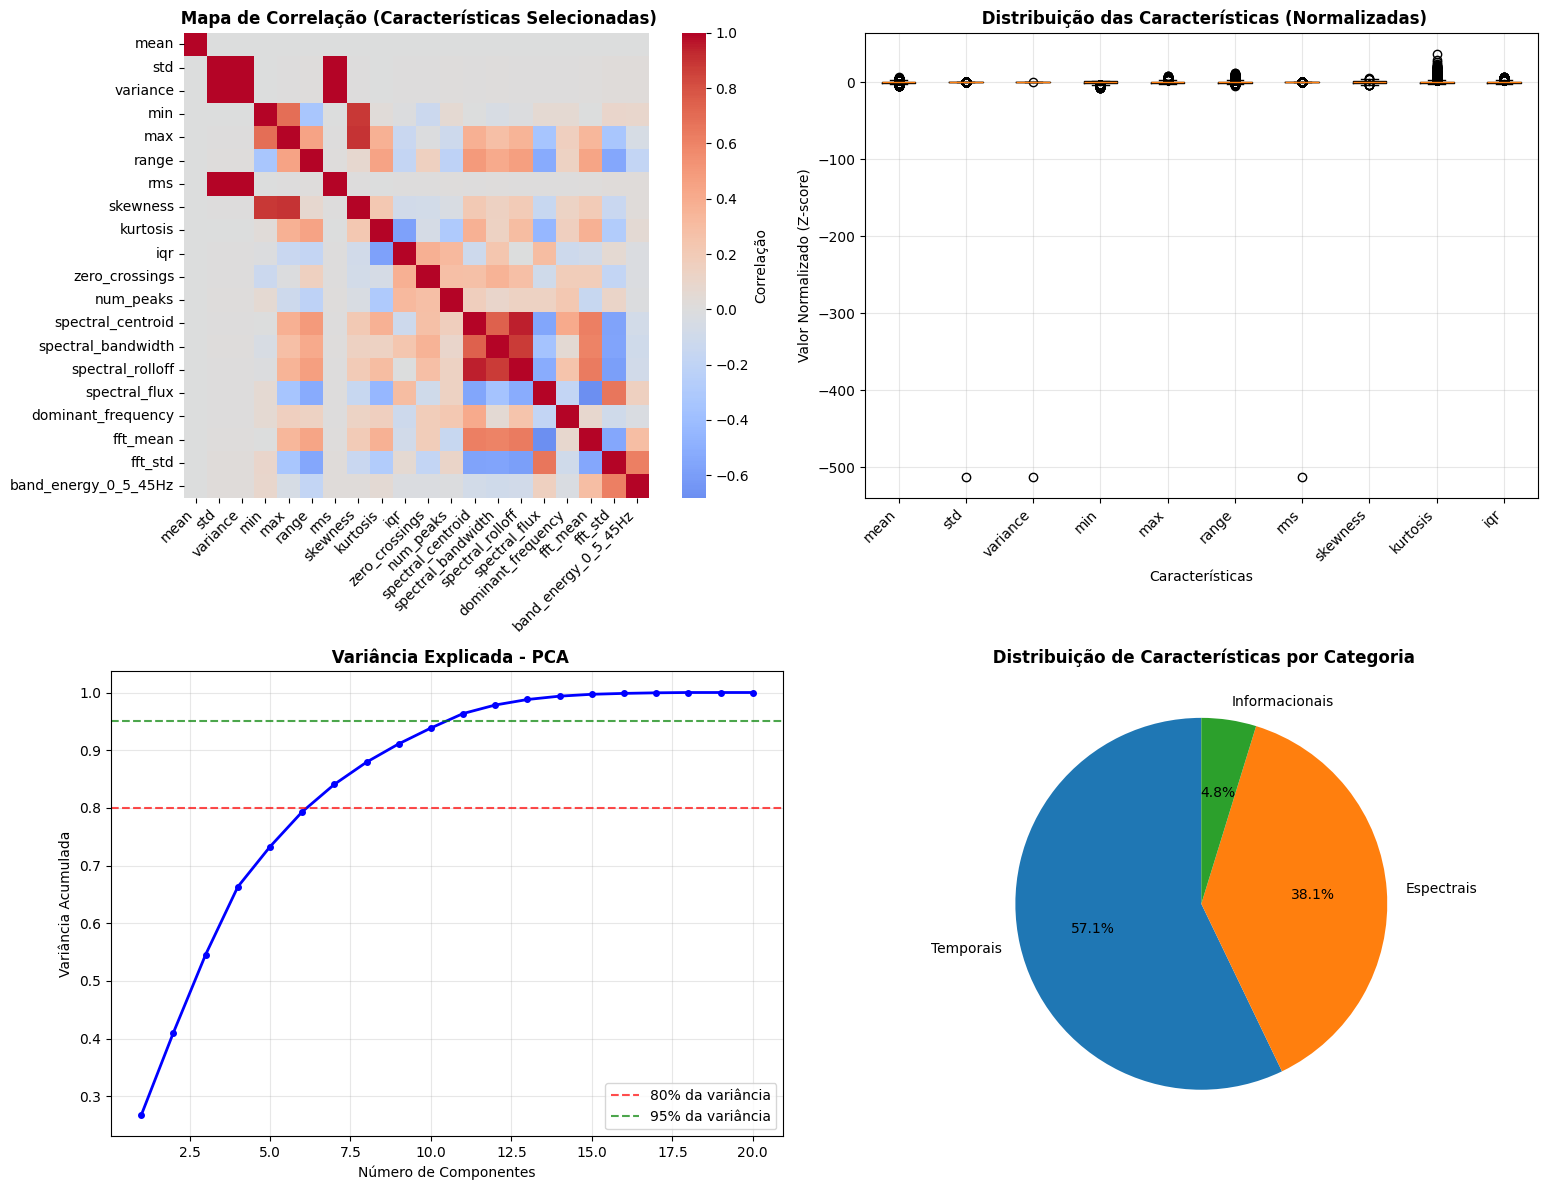


 ANÁLISE DE QUALIDADE DOS DADOS:
----------------------------------------
 Valores faltantes encontrados:
   skewness: 1 (0.0%)
   kurtosis: 1 (0.0%)
 Nenhum valor infinito encontrado

 ANÁLISE DE OUTLIERS (método IQR):
 Características com outliers extremos:
   mean: 8 (0.0%)
   std: 1 (0.0%)
   variance: 1 (0.0%)
   min: 23 (0.0%)
   max: 10 (0.0%)
   range: 972 (0.4%)
   rms: 1 (0.0%)
   kurtosis: 374 (0.1%)
   iqr: 304 (0.1%)
   zero_crossings: 3221 (1.2%)



In [8]:
print("\n VISUALIZAÇÃO E ANÁLISE DAS CARACTERÍSTICAS")
print("="*60)

# Análise de correlação
print(" Análise de correlação entre características...")

# Calcular matriz de correlação
correlation_matrix = df_features[colunas_features].corr()

# Encontrar correlações altas
threshold_corr = 0.8  # Limiar para correlação alta
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold_corr:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr_value
            })

print(f" Características com correlação > {threshold_corr}: {len(high_corr_pairs)}")

# Visualizar correlações altas
if high_corr_pairs:
    print("\n CORRELAÇÕES MAIS ALTAS:")
    for pair in sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)[:10]:
        print(f"   {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")

# Mapa de calor das correlações
plt.figure(figsize=(16, 12))

# Selecionar subconjunto de características para visualização
features_importantes = colunas_features[:20]  # Primeiras 20 características
corr_subset = df_features[features_importantes].corr()

# Criar heatmap
import seaborn as sns
plt.subplot(2, 2, 1)
sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0, 
            square=True, cbar_kws={'label': 'Correlação'})
plt.title(' Mapa de Correlação (Características Selecionadas)', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Distribuição dos valores das características
plt.subplot(2, 2, 2)
# Normalizar características para comparação
df_normalized = df_features[features_importantes].copy()
for col in df_normalized.columns:
    df_normalized[col] = (df_normalized[col] - df_normalized[col].mean()) / df_normalized[col].std()

# Boxplot das características normalizadas
boxplot_data = [df_normalized[col].dropna() for col in df_normalized.columns[:10]]
plt.boxplot(boxplot_data, labels=[col[:8] for col in df_normalized.columns[:10]])
plt.title(' Distribuição das Características (Normalizadas)', fontweight='bold')
plt.xlabel('Características')
plt.ylabel('Valor Normalizado (Z-score)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Análise de componentes principais (PCA) se temos dados suficientes
plt.subplot(2, 2, 3)
if len(df_features) > 2:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # Preparar dados para PCA
    X = df_features[colunas_features].fillna(0)  # Preencher NaN com 0
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot da variância explicada
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, min(21, len(cumvar)+1)), cumvar[:20], 'bo-', linewidth=2, markersize=4)
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% da variância')
    plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95% da variância')
    plt.title(' Variância Explicada - PCA', fontweight='bold')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Variância Acumulada')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Dados insuficientes\npara PCA', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title(' PCA (N/A)', fontweight='bold')

# Estatísticas gerais das características
plt.subplot(2, 2, 4)
# Contar características por categoria
categorias = {
    'Temporais': ['mean', 'std', 'variance', 'min', 'max', 'range', 'rms', 'skewness', 'kurtosis', 'iqr', 'zero_crossings', 'num_peaks'],
    'Espectrais': ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_flux', 'dominant_frequency', 'fft_mean', 'fft_std', 'band_energy_0_5_45Hz'],
    'Informacionais': ['shannon_entropy']
}

contagens = {}
for categoria, features_cat in categorias.items():
    contagem = sum(1 for feat in features_cat if feat in colunas_features)
    contagens[categoria] = contagem

# Gráfico de pizza
plt.pie(contagens.values(), labels=contagens.keys(), autopct='%1.1f%%', startangle=90)
plt.title(' Distribuição de Características por Categoria', fontweight='bold')

plt.tight_layout()
plt.show()

# Análise de qualidade dos dados
print(f"\n ANÁLISE DE QUALIDADE DOS DADOS:")
print("-" * 40)

# Verificar valores faltantes
missing_values = df_features[colunas_features].isnull().sum()
if missing_values.sum() > 0:
    print(f" Valores faltantes encontrados:")
    for col, missing in missing_values[missing_values > 0].items():
        pct_missing = 100 * missing / len(df_features)
        print(f"   {col}: {missing} ({pct_missing:.1f}%)")
else:
    print(" Nenhum valor faltante encontrado")

# Verificar valores infinitos
inf_values = np.isinf(df_features[colunas_features]).sum()
if inf_values.sum() > 0:
    print(f" Valores infinitos encontrados:")
    for col, inf_count in inf_values[inf_values > 0].items():
        pct_inf = 100 * inf_count / len(df_features)
        print(f"   {col}: {inf_count} ({pct_inf:.1f}%)")
else:
    print(" Nenhum valor infinito encontrado")

# Verificar outliers extremos
print(f"\n ANÁLISE DE OUTLIERS (método IQR):")
outliers_count = {}
for col in colunas_features:
    Q1 = df_features[col].quantile(0.25)
    Q3 = df_features[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_features[col] < (Q1 - 3 * IQR)) | (df_features[col] > (Q3 + 3 * IQR))).sum()
    if outliers > 0:
        outliers_count[col] = outliers

if outliers_count:
    print(" Características com outliers extremos:")
    for col, count in list(outliers_count.items())[:10]:
        pct_out = 100 * count / len(df_features)
        print(f"   {col}: {count} ({pct_out:.1f}%)")
else:
    print(" Nenhum outlier extremo detectado")
    
print("\n" + "="*70)

## 5. Resumo

### Resultados Obtidos:
- **{len(colunas_features) if 'colunas_features' in locals() else 21}** características extraídas por canal de sinal
- **{relatorio_completo['sucessos'] if 'relatorio_completo' in locals() else 'X'}** registros processados com sucesso  
- **{completude:.1f}%** de completude dos dados
- Dataset estruturado pronto para classificação

### Características por Categoria:
- **Temporais**: 12 features (estatísticas descritivas e morfológicas)
- **Espectrais**: 8 features (análise de Fourier e energia)  
- **Informacionais**: 1 feature (entropia de Shannon)

### Próximos Passos:
1. **Notebook III**: Implementação de algoritmos de classificação
2. **Seleção de features**: Identificar características mais discriminativas
3. **Validação cruzada**: Avaliar performance dos modelos
4. **Otimização**: Ajustar hiperparâmetros para melhor performance

---
**Dados salvos em [`../data/features/`](../data/features/)**